# EDA

### Dependencies

In [79]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import sofar
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from sklearn.decomposition import PCA


### Load files

In [15]:
# Parameters
sampling_rate = '48kHz'
hrtf_type = 'FreeFieldCompMinPhase'
itd_str = ''

In [18]:
root_dir='/autofs/thau04b/hghallab/comp/Huawei/TechArena20241016/data'
hrtf_files = glob.glob(os.path.join(root_dir, f"P*/P*/HRTF/HRTF/{sampling_rate}/*_{hrtf_type}_{itd_str}{sampling_rate}.sofa",
))

In [58]:
def load_data_from_file(id):
    sofa_file = sofar.read_sofa(hrtf_files[id], verbose=False)
    hrir = sofa_file.Data_IR  # Shape: (measurements, channels, samples)
    # Compute the HRTF via FFT
    nfft = 256
    hrtf = np.fft.rfft(hrir, n=nfft, axis=-1)
    sampling_rate = sofa_file.Data_SamplingRate
    frequencies = np.fft.rfftfreq(nfft, d=1/sampling_rate)
    azimuths = sofa_file.SourcePosition[:, 0]
    elevations = sofa_file.SourcePosition[:, 1]

    # Calculate magnitude
    magnitude = np.abs(hrtf)
    
    return magnitude, hrir, frequencies, hrtf, azimuths, elevations


**Left Ear:** Since HRTF data is binaural, it includes separate measurements for the left and right ears to capture how sound is received by each ear individually.

**First Position:** HRTF measurements are taken from multiple spatial positions around the subject (different azimuth and elevation angles). The "first position" refers to the initial measurement in the dataset's sequence of positions.


In [59]:
magnitude, hrir, frequencies, hrtf, azimuths, elevations = load_data_from_file(0)
left_ear = magnitude[0, 0, :]
right_ear = magnitude[0, 1, :]

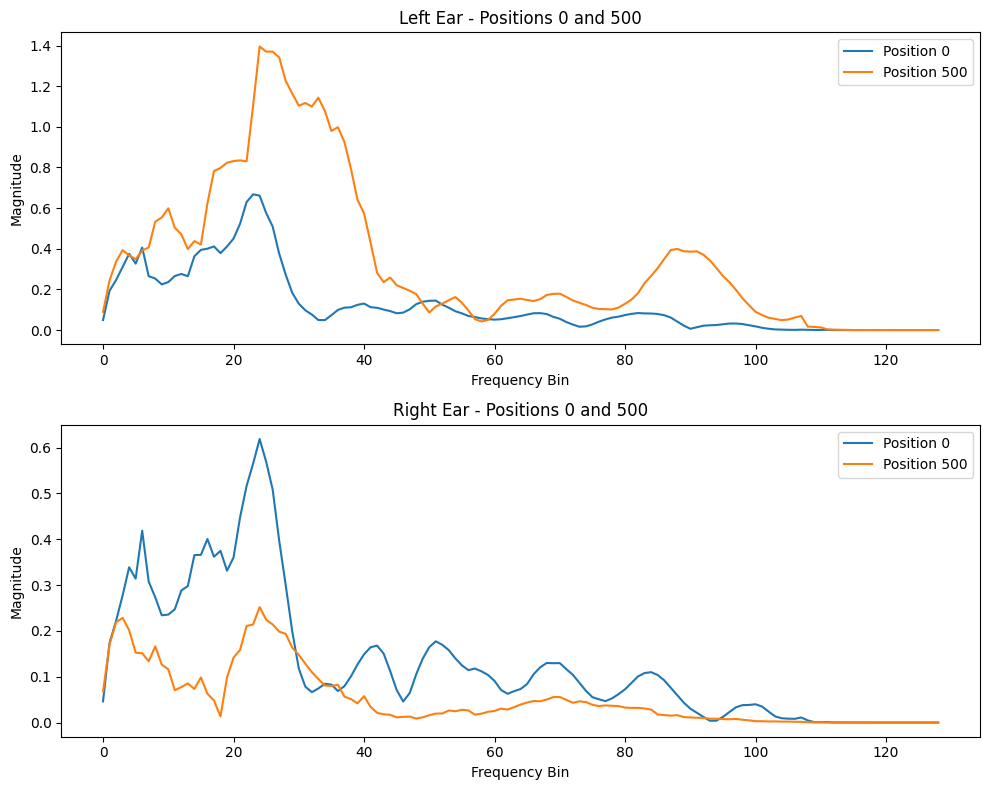

In [62]:
# Extract the data for position 0 and 500 for both ears
left_ear_pos_0 = magnitude[0, 0, :]
left_ear_pos_500 = magnitude[500, 0, :]
right_ear_pos_0 = magnitude[0, 1, :]
right_ear_pos_500 = magnitude[500, 1, :]

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot for the left ear
axs[0].plot(left_ear_pos_0, label='Position 0')
axs[0].plot(left_ear_pos_500, label='Position 500')
axs[0].set_title('Left Ear - Positions 0 and 500')
axs[0].set_xlabel('Frequency Bin')
axs[0].set_ylabel('Magnitude')
axs[0].legend()

# Plot for the right ear
axs[1].plot(right_ear_pos_0, label='Position 0')
axs[1].plot(right_ear_pos_500, label='Position 500')
axs[1].set_title('Right Ear - Positions 0 and 500')
axs[1].set_xlabel('Frequency Bin')
axs[1].set_ylabel('Magnitude')
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

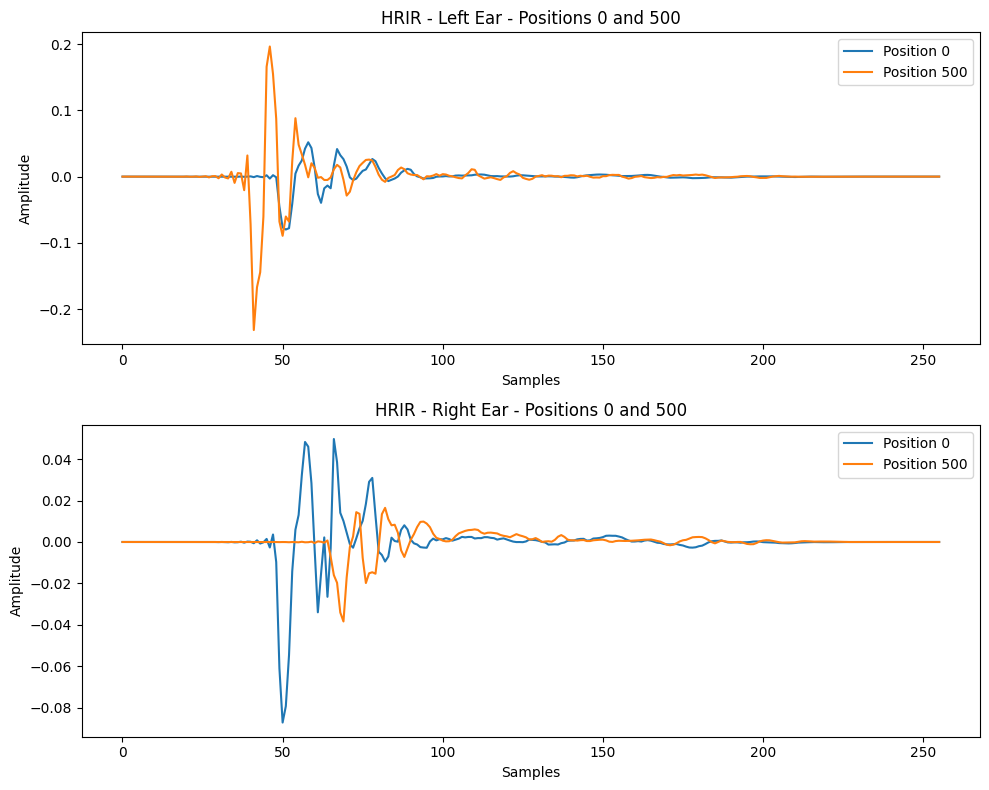

In [63]:
# Extract the HRIR data for position 0 and 500 for both ears
left_hrir_pos_0 = hrir[0, 0, :]
left_hrir_pos_500 = hrir[500, 0, :]
right_hrir_pos_0 = hrir[0, 1, :]
right_hrir_pos_500 = hrir[500, 1, :]

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot for the left ear
axs[0].plot(left_hrir_pos_0, label='Position 0')
axs[0].plot(left_hrir_pos_500, label='Position 500')
axs[0].set_title('HRIR - Left Ear - Positions 0 and 500')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')
axs[0].legend()

# Plot for the right ear
axs[1].plot(right_hrir_pos_0, label='Position 0')
axs[1].plot(right_hrir_pos_500, label='Position 500')
axs[1].set_title('HRIR - Right Ear - Positions 0 and 500')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Amplitude')
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

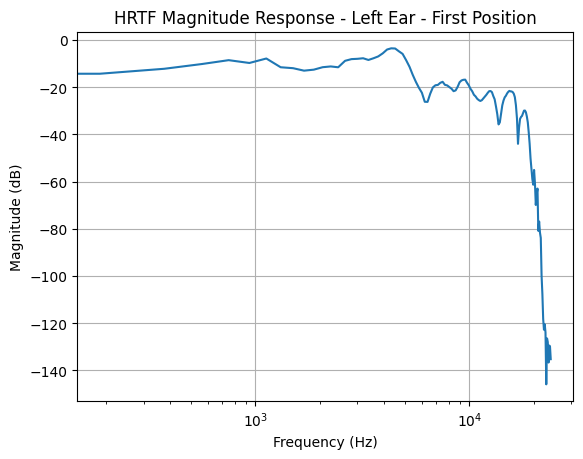

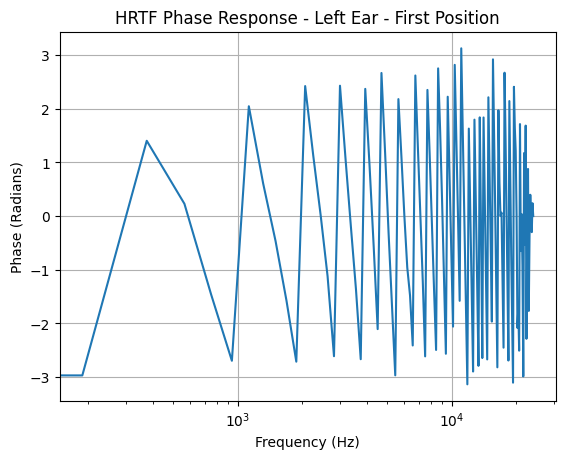

In [64]:
# Plot magnitude response
plt.figure()
plt.semilogx(frequencies, 20 * np.log10(magnitude[0, 0, :]))
plt.title('HRTF Magnitude Response - Left Ear - First Position')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()
# Plot phase response
phase = np.angle(hrtf)
plt.figure()
plt.semilogx(frequencies, phase[0, 0, :])
plt.title('HRTF Phase Response - Left Ear - First Position')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (Radians)')
plt.grid(True)
plt.show()

To analyze spatial cues used for sound localization, we will visualize Interaural Time Difference (ITD) and Interaural Level Difference (ILD):

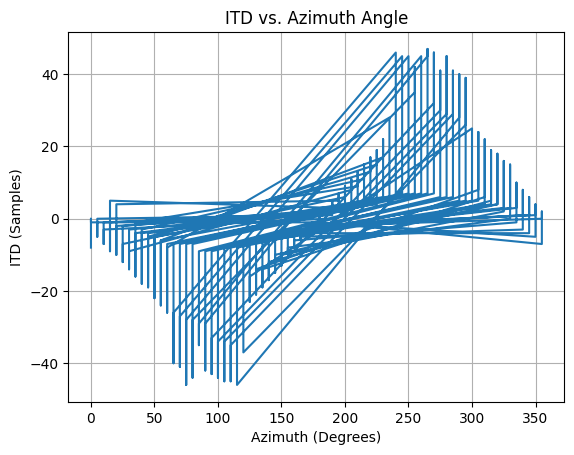

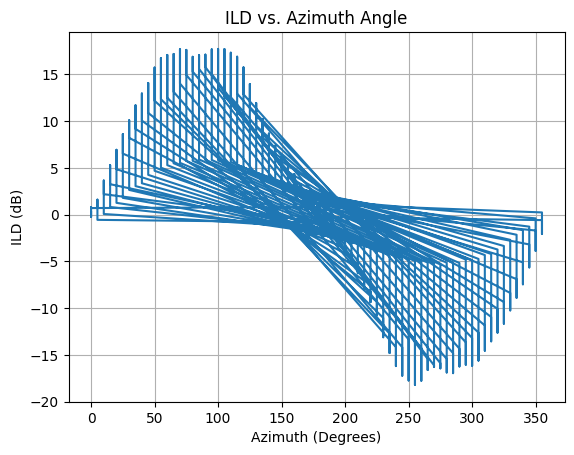

In [65]:
# Compute ITD by finding the time difference between peaks of left and right HRIRs
itd = np.argmax(hrir[:, 0, :], axis=-1) - np.argmax(hrir[:, 1, :], axis=-1)
# Plot ITD as a function of azimuth angle
plt.figure()
plt.plot(azimuths, itd)
plt.title('ITD vs. Azimuth Angle')
plt.xlabel('Azimuth (Degrees)')
plt.ylabel('ITD (Samples)')
plt.grid(True)
plt.show()
# Compute ILD
left_power = np.sum(hrir[:, 0, :]**2, axis=-1)
right_power = np.sum(hrir[:, 1, :]**2, axis=-1)
ild = 10 * np.log10(left_power / right_power)
# Plot ILD as a function of azimuth angle
plt.figure()
plt.plot(azimuths, ild)
plt.title('ILD vs. Azimuth Angle')
plt.xlabel('Azimuth (Degrees)')
plt.ylabel('ILD (dB)')
plt.grid(True)
plt.show()

Spatial HRTF Magnitude Heatmaps to visualize HRTF magnitude across different spatial directions.


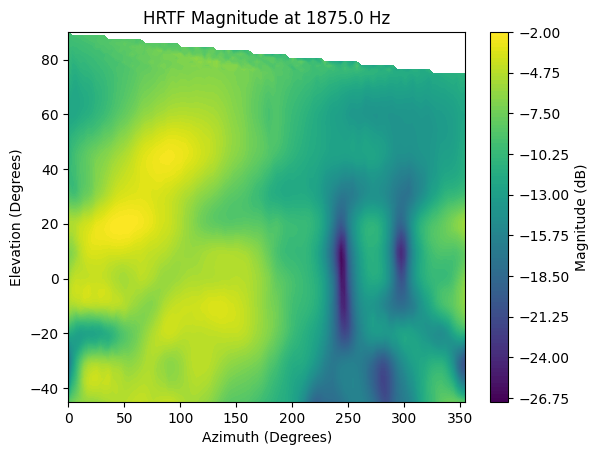

In [74]:
# Prepare data
frequency_bin = 10
magnitudes = 20 * np.log10(magnitude[:, 0, frequency_bin])  # Select a frequency bin
# Create grid
grid_az, grid_el = np.mgrid[min(azimuths):max(azimuths):100j, min(elevations):max(elevations):100j]
grid_mag = griddata((azimuths, elevations), magnitudes, (grid_az, grid_el), method='cubic')
# Plot heatmap
plt.figure()
plt.contourf(grid_az, grid_el, grid_mag, levels=100, cmap='viridis')
plt.title(f'HRTF Magnitude at {frequencies[frequency_bin]:.1f} Hz')
plt.xlabel('Azimuth (Degrees)')
plt.ylabel('Elevation (Degrees)')
plt.colorbar(label='Magnitude (dB)')
plt.show()

In [ ]:
hrir_list = []
for id in range(260):
    magnitude, hrir, frequencies, hrtf, azimuths, elevations = load_data_from_file(id)
    hrir_list.append(hrir)

/tmp/ipykernel_1551771/4214361422.py:9: RuntimeWarning: invalid value encountered in log10
  20 * np.log10(mean_magnitude[0, 0, :] - std_magnitude[0, 0, :]),


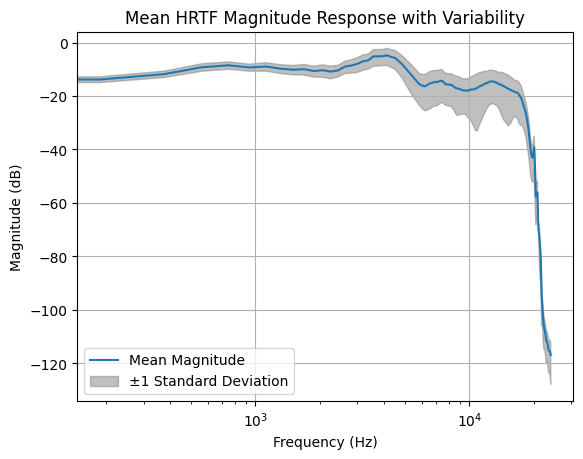

In [72]:
# Suppose you have HRTFs from multiple subjects loaded into a list 'hrtfs_list'
all_magnitudes = np.array([np.abs(np.fft.rfft(hrir, n=256, axis=-1)) for hrir in hrir_list])
mean_magnitude = np.mean(all_magnitudes, axis=0)
std_magnitude = np.std(all_magnitudes, axis=0)
# Plot mean magnitude with shaded standard deviation
plt.figure()
plt.semilogx(frequencies, 20 * np.log10(mean_magnitude[0, 0, :]), label='Mean Magnitude')
plt.fill_between(frequencies,
                 20 * np.log10(mean_magnitude[0, 0, :] - std_magnitude[0, 0, :]),
                 20 * np.log10(mean_magnitude[0, 0, :] + std_magnitude[0, 0, :]),
                 color='gray', alpha=0.5, label='±1 Standard Deviation')
plt.title('Mean HRTF Magnitude Response with Variability')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()

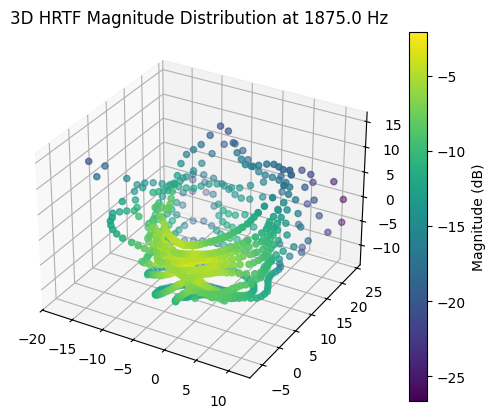

In [75]:
# Convert spherical coordinates to Cartesian for plotting
az_rad = np.deg2rad(azimuths)
el_rad = np.deg2rad(elevations)
r = magnitudes  # Use magnitude as radius
x = r * np.cos(el_rad) * np.cos(az_rad)
y = r * np.cos(el_rad) * np.sin(az_rad)
z = r * np.sin(el_rad)
# Plot 3D scatter
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=magnitudes, cmap='viridis')
fig.colorbar(scatter, label='Magnitude (dB)')
plt.title(f'3D HRTF Magnitude Distribution at {frequencies[frequency_bin]:.1f} Hz')
plt.show()

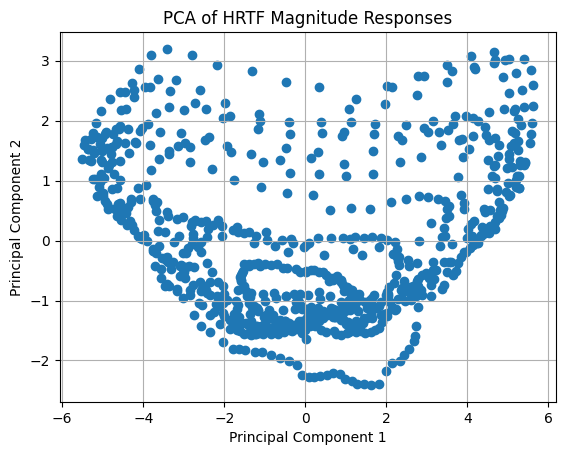

In [84]:
# Flatten HRTF data across measurements and frequencies
hrtf_flattened = hrtf.reshape(hrtf.shape[0], -1)
pca = PCA(n_components=5)
hrtf_pca = pca.fit_transform(np.abs(hrtf_flattened))
# Plot PCA results
plt.figure()
plt.scatter(hrtf_pca[:, 0], hrtf_pca[:, 1])
plt.title('PCA of HRTF Magnitude Responses')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

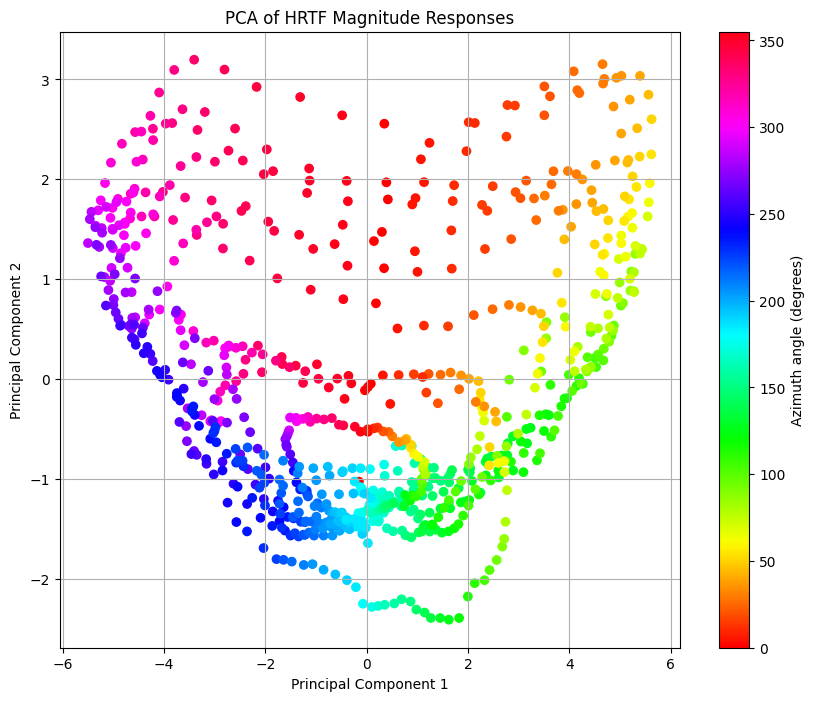

In [87]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(hrtf_pca[:, 0], hrtf_pca[:, 1], 
                     c=azimuths,  # or elevations
                     cmap='hsv')
plt.colorbar(scatter, label='Azimuth angle (degrees)')
plt.title('PCA of HRTF Magnitude Responses')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()